In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import mangoenv
import utils
import nets
import optuna

In [2]:
import matplotlib.pyplot as plt

def smooth(x, w=0.01):
    return jnp.convolve(x, jnp.ones(int(w * len(x))) / int(w * len(x)), mode="valid")

def plot_rewards(rewards):
    for rew in rewards:
        plt.plot(smooth(rew))
    plt.plot(smooth(rewards.mean(axis=0)), label="mean", color="black", linewidth=3)
    plt.grid()
    plt.ylim(0,1)
    plt.show()

In [3]:
def setup_replay_buffer(env, rng_key, n_rollouts, rollout_steps):
    episodes = utils.multi_random_rollout(env, rng_key, rollout_steps, n_rollouts)
    replay_buffer = utils.CircularBuffer.store_episodes(episodes)
    return replay_buffer


def setup_dql_state(env, rng_key, lr, cell_scale):
    reward_fn = actions.get_reward_fn(cell_scale)
    beta_fn = actions.get_beta_fn(cell_scale)
    qnet = nets.MultiTaskQnet(env.action_space.n, n_comands=5)
    dql_state = qlearning.MultiDQLTrainState.create(
        rng_key, qnet, env, reward_fn=reward_fn, beta_fn=beta_fn, lr=lr
    )
    return dql_state


def eval_policy(env, dql_state, rng_key, episodes, steps):
    def eval_single(rng_key):
        transitions = dql_state.greedy_rollout(env, rng_key, steps)
        episodes = jnp.clip(transitions.done.sum(), a_min=1)
        rewards = transitions.reward.sum()
        return rewards, episodes

    rewards, episodes = jax.vmap(eval_single)(jax.random.split(rng_key, episodes))
    return rewards.sum() / episodes.sum()


def train_stage(rng_key, env, dql_state, replay_buffer, n_train_iter, batch_size):
    pbar = tqdm(total=n_train_iter, desc="Training")

    def train_step(dql_state, rng_key):
        rng_train, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key)
        )
        dql_state = dql_state.update_params(replay_buffer.sample(rng_train, batch_size))
        accuracy = eval_policy(env, dql_state, rng_eval, episodes=64, steps=5)
        return dql_state, accuracy

    rng_steps = jax.random.split(rng_key, n_train_iter)
    dql_state, accuracy_evolution = jax.lax.scan(train_step, dql_state, rng_steps)
    return dql_state, accuracy_evolution


def get_env_setup_fn(map_scale, p, cell_scales):
    def setup_base_env(rng_key):
        env = frozen_lake.FrozenLake.make_random(rng_key, map_scale, p)
        return env

    if len(cell_scales) == 0:
        return setup_base_env

    setup_lower_layer = get_env_setup_fn(map_scale, p, cell_scales[:-1])

    storage_path = f"{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"
    best_trial = optuna.load_study(
        study_name="mango",
        storage=f"sqlite:///optuna_studies/{storage_path}",
        pruner=optuna.pruners.MedianPruner(),
    ).best_trial

    lr = 10 ** best_trial.params["log_lr"]
    rollout_steps = 2 ** best_trial.params["log_rollout_steps"]
    batch_size = 2 ** best_trial.params["log_batch_size"]
    n_rollouts = best_trial.user_attrs["n_rollouts"]
    train_iter = best_trial.user_attrs["train_iter"]

    def setup_abs_env(rng_key):
        rng_env, rng_rollout, rng_init, rng_train = jax.random.split(rng_key, 4)

        env = setup_lower_layer(rng_env)
        replay_buffer = setup_replay_buffer(env, rng_rollout, n_rollouts, rollout_steps)
        dql_state = setup_dql_state(env, rng_init, lr, cell_scales[-1])
        dql_state, accuracy_evol = train_stage(
            rng_train, env, dql_state, replay_buffer, train_iter, batch_size
        )
        abs_env = mangoenv.MangoEnv(env, dql_state, max_steps=8)
        return abs_env

    return setup_abs_env

In [4]:
def get_objective_fn(map_scale, cell_scales, max_steps, p=0.5, n_sims=16):
    multi_env_setup = jax.jit(jax.vmap(get_env_setup_fn(map_scale, p, cell_scales[:-1])))
    multi_replay_buffer_setup = jax.jit(
        jax.vmap(setup_replay_buffer, in_axes=(0, 0, None, None)),
        static_argnames=("n_rollouts", "rollout_steps"),
    )
    multi_dql_state_setup = jax.jit(
        jax.vmap(partial(setup_dql_state, cell_scale=cell_scales[-1]), in_axes=(0, 0, None)),
        static_argnames=("lr",),
    )
    multi_train_stage = jax.jit(
        jax.vmap(train_stage, in_axes=(0, 0, 0, 0, None, None)),
        static_argnames=("n_train_iter", "batch_size"),
    )

    def objective(trial: optuna.Trial) -> jnp.float_:
        lr = 10 ** trial.suggest_float("log_lr", -5, -3, step=0.5)
        rollout_steps = 2 ** trial.suggest_int("log_rollout_steps", 2, 7)  # 4 to 128
        batch_size = 2 ** trial.suggest_int("log_batch_size", 8, 10)  # 256 to 1024
        n_rollouts = max_steps // rollout_steps
        train_iter = max_steps // batch_size

        # attributes
        seed = trial.number
        trial.set_user_attr("seed", seed)
        trial.set_user_attr("map_scale", map_scale)
        trial.set_user_attr("cell_scales", cell_scales)
        trial.set_user_attr("train_iter", train_iter)
        trial.set_user_attr("n_rollouts", n_rollouts)

        rng_key = jax.random.PRNGKey(seed)
        rng_env, rng_rollout, rng_init, rng_train = jax.random.split(rng_key, 4)
        rng_env = jax.random.split(rng_env, n_sims)
        rng_rollout = jax.random.split(rng_rollout, n_sims)
        rng_init = jax.random.split(rng_init, n_sims)
        rng_train = jax.random.split(rng_train, n_sims)

        envs = multi_env_setup(rng_env)
        replay_buffers = multi_replay_buffer_setup(envs, rng_rollout, n_rollouts, rollout_steps)
        dql_states = multi_dql_state_setup(envs, rng_init, lr)
        dql_states, accuracy_evol = multi_train_stage(
            rng_train, envs, dql_states, replay_buffers, train_iter, batch_size
        )
        plot_rewards(accuracy_evol)
        trial.set_user_attr("accuracy_evol", np.asarray(accuracy_evol).tolist())
        return accuracy_evol.mean()

    return objective

[I 2024-03-01 19:26:53,632] A new study created in RDB with name: mango


  0%|          | 0/128 [00:00<?, ?it/s]

Training:   0%|          | 0/512 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

Random Rollout:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/512 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

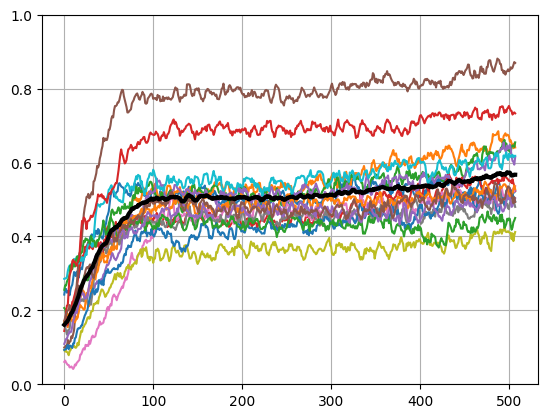

[I 2024-03-01 19:27:09,189] Trial 0 finished with value: 0.49176737666130066 and parameters: {'log_lr': -4.0, 'log_rollout_steps': 2, 'log_batch_size': 8}. Best is trial 0 with value: 0.49176737666130066.


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

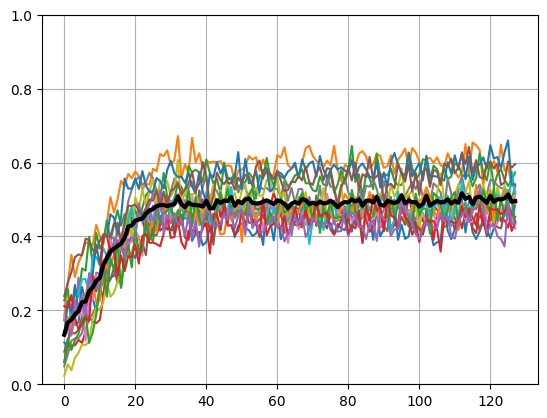

[I 2024-03-01 19:27:17,076] Trial 1 finished with value: 0.45959633588790894 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 2, 'log_batch_size': 10}. Best is trial 0 with value: 0.49176737666130066.


Random Rollout:   0%|          | 0/64 [00:00<?, ?it/s]

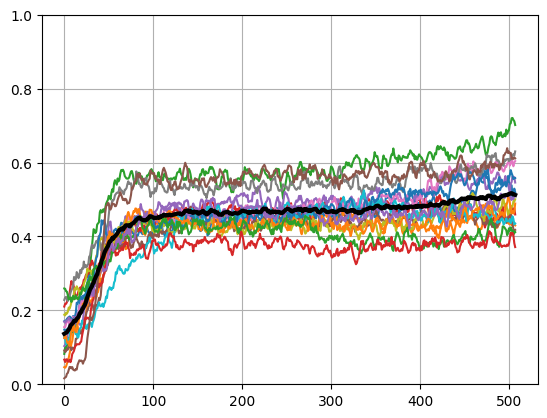

[I 2024-03-01 19:27:26,768] Trial 2 finished with value: 0.4474428594112396 and parameters: {'log_lr': -4.0, 'log_rollout_steps': 6, 'log_batch_size': 8}. Best is trial 0 with value: 0.49176737666130066.


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

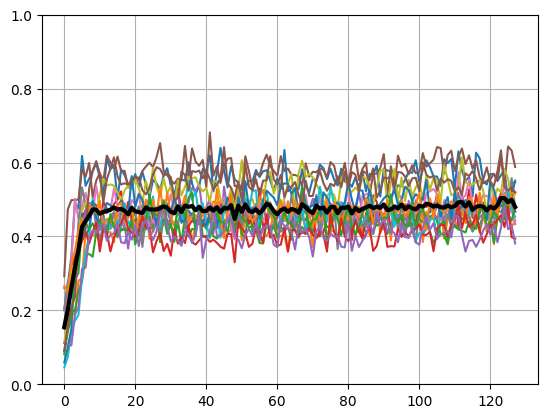

[I 2024-03-01 19:27:33,953] Trial 3 finished with value: 0.4669691324234009 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 6, 'log_batch_size': 10}. Best is trial 0 with value: 0.49176737666130066.


Random Rollout:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/128 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

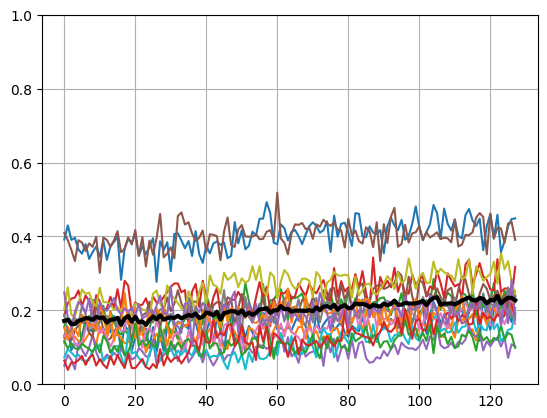

[I 2024-03-01 19:27:42,386] Trial 4 finished with value: 0.20060762763023376 and parameters: {'log_lr': -5.0, 'log_rollout_steps': 4, 'log_batch_size': 10}. Best is trial 0 with value: 0.49176737666130066.


Training:   0%|          | 0/256 [00:00<?, ?it/s]

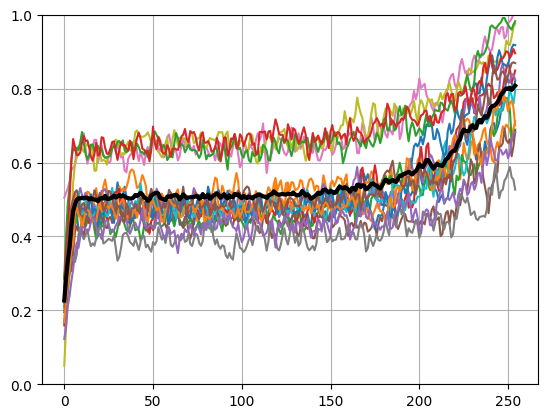

[I 2024-03-01 19:27:50,707] Trial 5 finished with value: 0.5493621826171875 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 2, 'log_batch_size': 9}. Best is trial 5 with value: 0.5493621826171875.


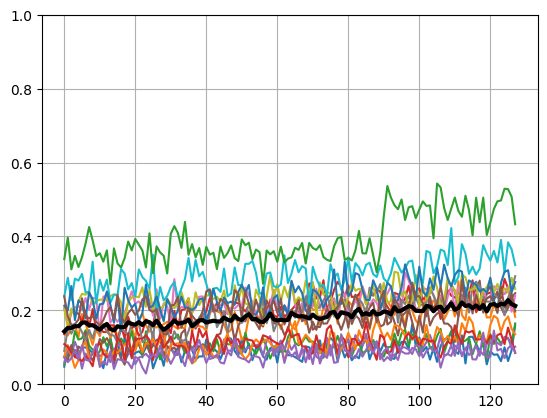

[I 2024-03-01 19:27:56,119] Trial 6 finished with value: 0.18299183249473572 and parameters: {'log_lr': -5.0, 'log_rollout_steps': 2, 'log_batch_size': 10}. Best is trial 5 with value: 0.5493621826171875.


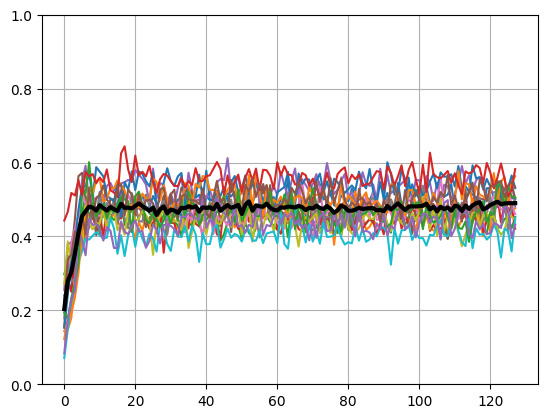

[I 2024-03-01 19:28:01,482] Trial 7 finished with value: 0.4712965488433838 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 6, 'log_batch_size': 10}. Best is trial 5 with value: 0.5493621826171875.


Random Rollout:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/512 [00:00<?, ?it/s]

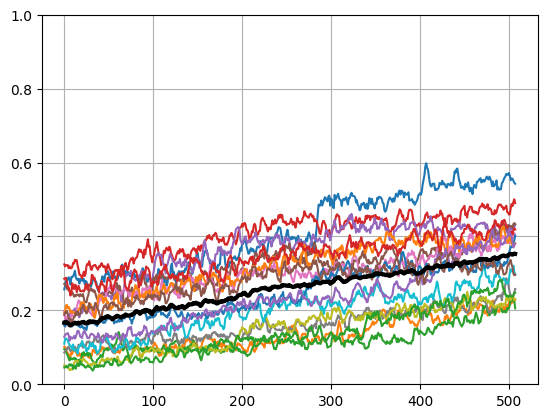

[I 2024-03-01 19:28:12,817] Trial 8 finished with value: 0.25800150632858276 and parameters: {'log_lr': -5.0, 'log_rollout_steps': 3, 'log_batch_size': 8}. Best is trial 5 with value: 0.5493621826171875.


Training:   0%|          | 0/256 [00:00<?, ?it/s]

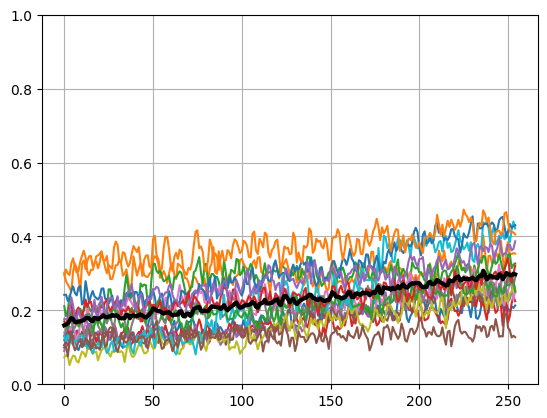

[I 2024-03-01 19:28:20,849] Trial 9 finished with value: 0.2292247712612152 and parameters: {'log_lr': -5.0, 'log_rollout_steps': 6, 'log_batch_size': 9}. Best is trial 5 with value: 0.5493621826171875.


Training:   0%|          | 0/256 [00:00<?, ?it/s]

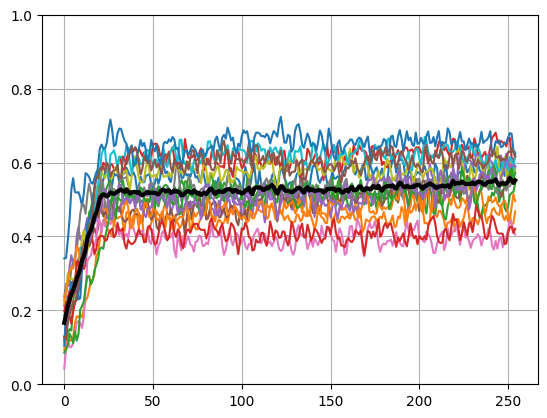

[I 2024-03-01 19:28:28,628] Trial 10 finished with value: 0.5124409198760986 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 4, 'log_batch_size': 9}. Best is trial 5 with value: 0.5493621826171875.


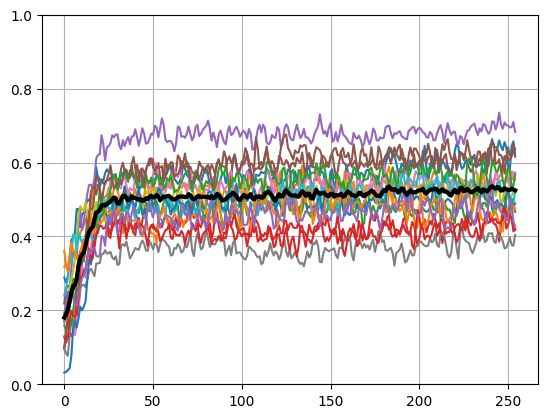

[I 2024-03-01 19:28:34,991] Trial 11 finished with value: 0.49848228693008423 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 4, 'log_batch_size': 9}. Best is trial 5 with value: 0.5493621826171875.


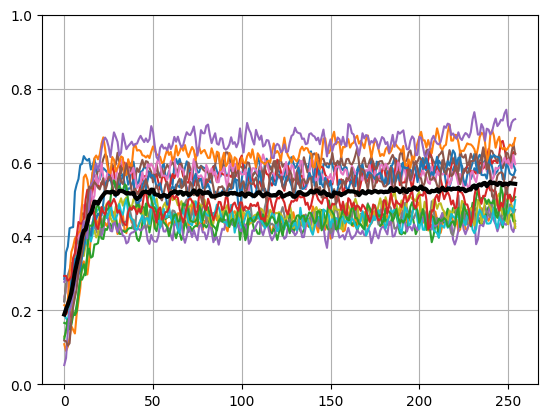

[I 2024-03-01 19:28:41,415] Trial 12 finished with value: 0.5077812075614929 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 3, 'log_batch_size': 9}. Best is trial 5 with value: 0.5493621826171875.


Random Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

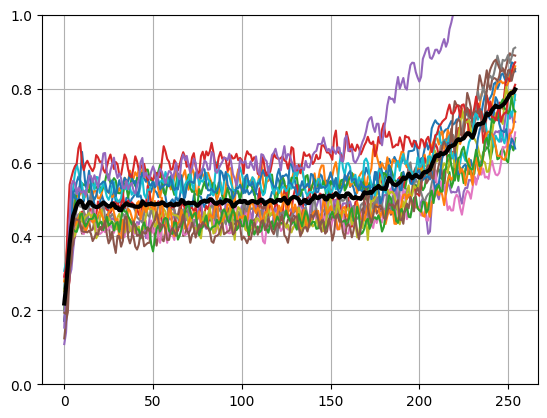

[I 2024-03-01 19:28:48,876] Trial 13 finished with value: 0.5353400707244873 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 5, 'log_batch_size': 9}. Best is trial 5 with value: 0.5493621826171875.


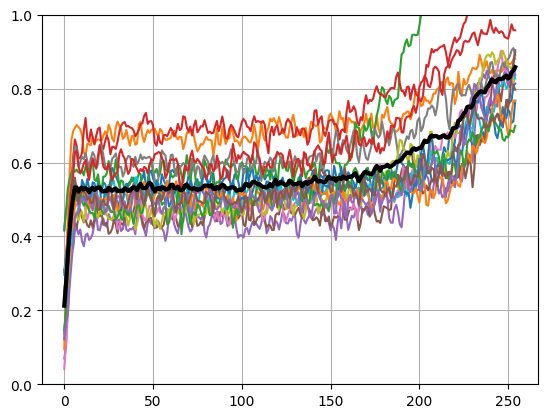

[I 2024-03-01 19:28:55,220] Trial 14 finished with value: 0.5854439735412598 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 5, 'log_batch_size': 9}. Best is trial 14 with value: 0.5854439735412598.


Random Rollout:   0%|          | 0/128 [00:00<?, ?it/s]

Training:   0%|          | 0/256 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

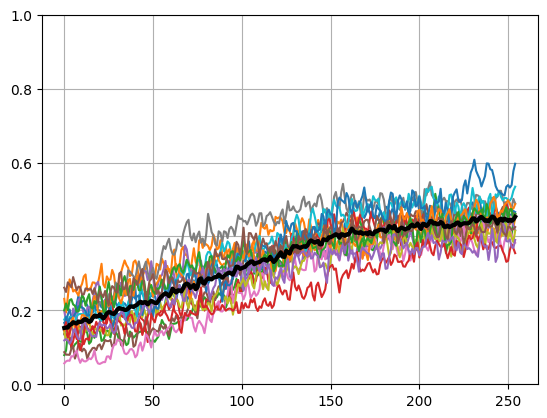

[I 2024-03-01 19:29:04,493] Trial 15 finished with value: 0.3359415531158447 and parameters: {'log_lr': -4.5, 'log_rollout_steps': 7, 'log_batch_size': 9}. Best is trial 14 with value: 0.5854439735412598.


Training:   0%|          | 0/512 [00:00<?, ?it/s]

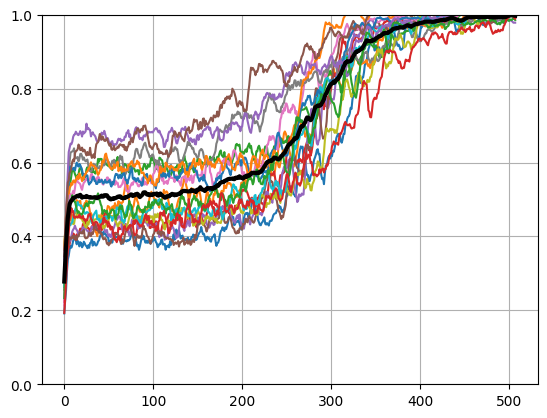

[I 2024-03-01 19:29:14,219] Trial 16 finished with value: 0.7220268249511719 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 5, 'log_batch_size': 8}. Best is trial 16 with value: 0.7220268249511719.


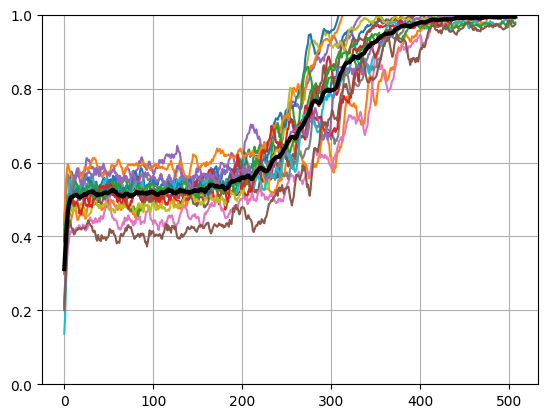

[I 2024-03-01 19:29:22,475] Trial 17 finished with value: 0.723312258720398 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 5, 'log_batch_size': 8}. Best is trial 17 with value: 0.723312258720398.


Training:   0%|          | 0/512 [00:00<?, ?it/s]

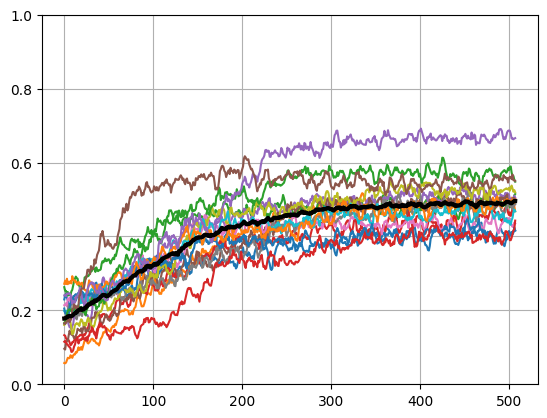

[I 2024-03-01 19:29:32,304] Trial 18 finished with value: 0.4119628071784973 and parameters: {'log_lr': -4.5, 'log_rollout_steps': 5, 'log_batch_size': 8}. Best is trial 17 with value: 0.723312258720398.


Training:   0%|          | 0/512 [00:00<?, ?it/s]

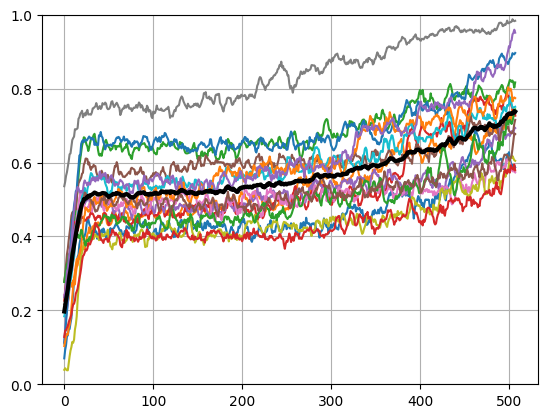

[I 2024-03-01 19:29:42,261] Trial 19 finished with value: 0.5643496513366699 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 7, 'log_batch_size': 8}. Best is trial 17 with value: 0.723312258720398.


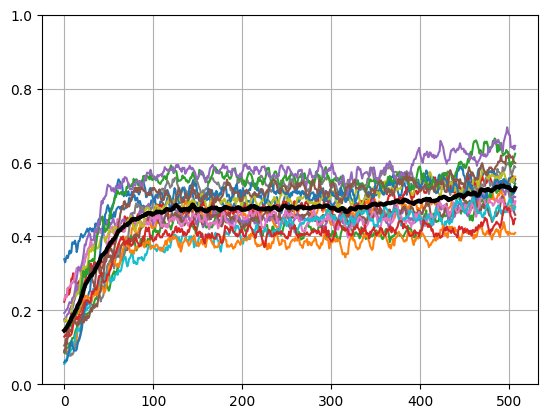

[I 2024-03-01 19:29:50,675] Trial 20 finished with value: 0.4592853784561157 and parameters: {'log_lr': -4.0, 'log_rollout_steps': 5, 'log_batch_size': 8}. Best is trial 17 with value: 0.723312258720398.


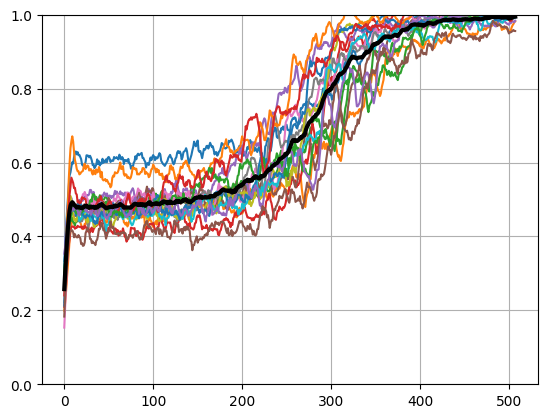

[I 2024-03-01 19:29:58,982] Trial 21 finished with value: 0.7069026827812195 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 5, 'log_batch_size': 8}. Best is trial 17 with value: 0.723312258720398.


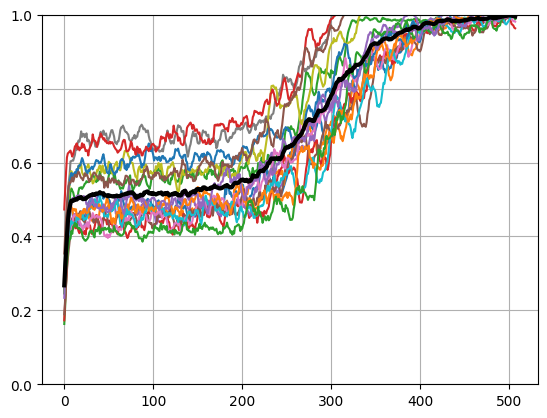

[I 2024-03-01 19:30:07,330] Trial 22 finished with value: 0.7151378393173218 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 5, 'log_batch_size': 8}. Best is trial 17 with value: 0.723312258720398.


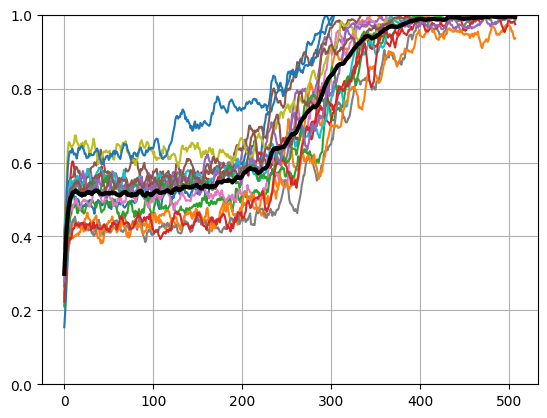

[I 2024-03-01 19:30:15,866] Trial 23 finished with value: 0.7309403419494629 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 4, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


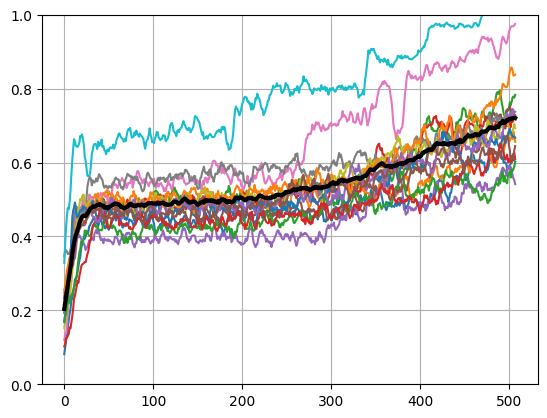

[I 2024-03-01 19:30:24,390] Trial 24 finished with value: 0.5439794063568115 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 3, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


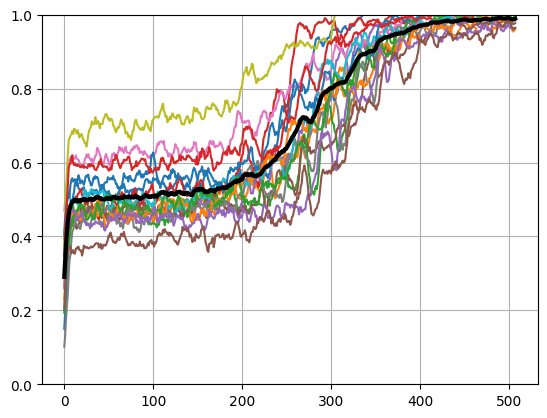

[I 2024-03-01 19:30:32,756] Trial 25 finished with value: 0.7157294750213623 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 4, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


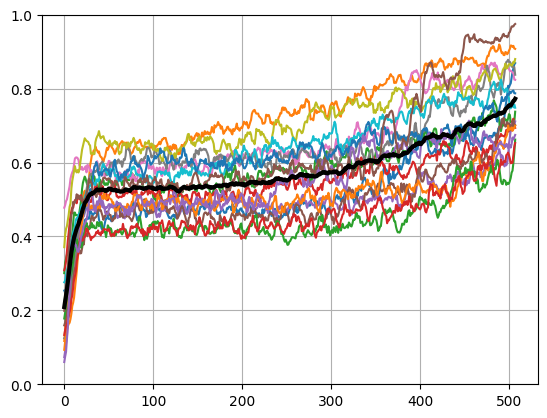

[I 2024-03-01 19:30:41,141] Trial 26 finished with value: 0.5783878564834595 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 4, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


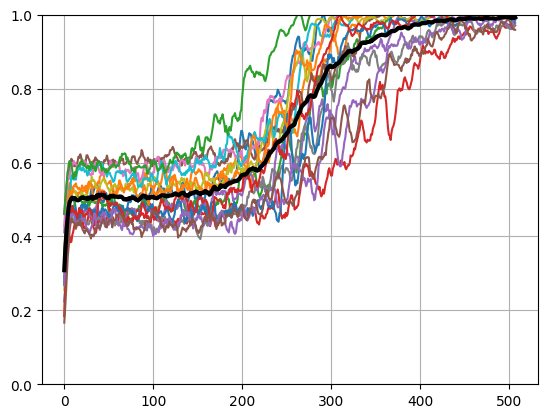

[I 2024-03-01 19:30:49,567] Trial 27 finished with value: 0.728766918182373 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 3, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


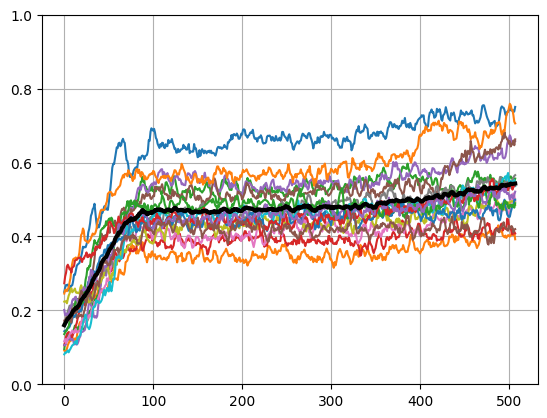

[I 2024-03-01 19:30:58,068] Trial 28 finished with value: 0.4593470096588135 and parameters: {'log_lr': -4.0, 'log_rollout_steps': 3, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


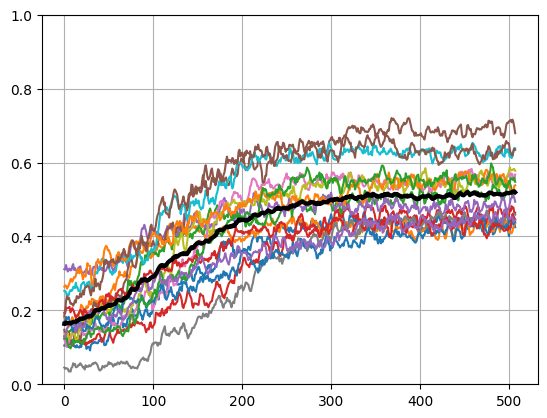

[I 2024-03-01 19:31:06,560] Trial 29 finished with value: 0.4184706211090088 and parameters: {'log_lr': -4.5, 'log_rollout_steps': 3, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


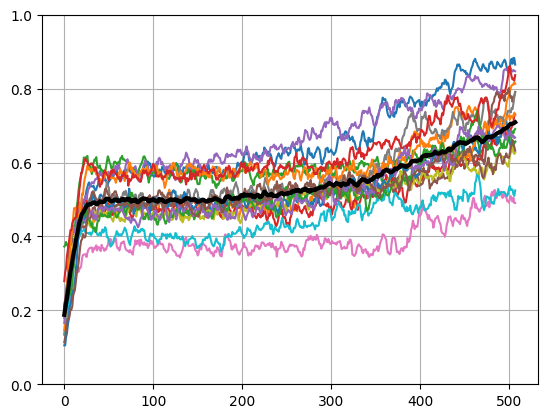

[I 2024-03-01 19:31:14,987] Trial 30 finished with value: 0.5411679744720459 and parameters: {'log_lr': -3.5, 'log_rollout_steps': 4, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


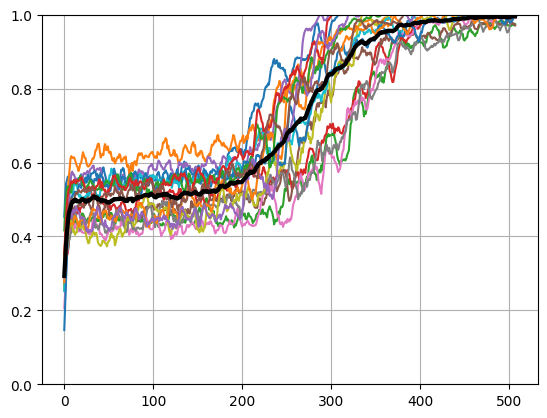

[I 2024-03-01 19:31:23,327] Trial 31 finished with value: 0.7255809307098389 and parameters: {'log_lr': -3.0, 'log_rollout_steps': 4, 'log_batch_size': 8}. Best is trial 23 with value: 0.7309403419494629.


In [7]:
map_scale = 2
cell_scales = (1,2)

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"
study = optuna.create_study(
    study_name=f"mango",
    storage=storage_path,
    load_if_exists=True,
    direction="maximize",
)
study.optimize(
    get_objective_fn(map_scale, cell_scales, max_steps=1024*128),
    n_trials=128,
    show_progress_bar=True,
)

In [6]:
map_scale = 2
cell_scales = (1,)
storage_path = f"{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"

cmd_ = f"optuna-dashboard 'sqlite:///optuna_studies/{storage_path}'"
# getipython().system(cmd)